In [36]:
import argparse
from os.path import dirname
import torch
import torchvision
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

from utils.models import PreprocessLayer
from utils.models import Classifier
from torch.utils.tensorboard import SummaryWriter
from utils.loader import Loader
from utils.loss import cross_entropy_loss_and_accuracy
from utils.dataset import NCaltech101
from torch.utils.data.dataloader import default_collate


In [37]:
torch.manual_seed(777)
np.random.seed(777)

In [38]:
validation_dataset="/ws/data/N-Caltech101/validation/"
training_dataset="/ws/data/N-Caltech101/training/"
log_dir="/ws/external/log_1.4_b4/temp"
device="cuda:0"
num_workers=4
pin_memory=True
batch_size=4
num_epochs=2
save_every_n_epochs=2
checkpoint = "/ws/external/log_1.4_b4/model_best.pth" # model_best.pth checkpoint_13625_0.5990.pth
    
    
assert os.path.isdir(dirname(log_dir)), f"Log directory root {dirname(log_dir)} not found."
assert os.path.isdir(validation_dataset), f"Validation dataset directory {validation_dataset} not found."
assert os.path.isdir(training_dataset), f"Training dataset directory {training_dataset} not found."

print(f"----------------------------\n"
      f"Starting training with \n"
      f"num_epochs: {num_epochs}\n"
      f"batch_size: {batch_size}\n"
      f"device: {device}\n"
      f"log_dir: {log_dir}\n"
      f"training_dataset: {training_dataset}\n"
      f"validation_dataset: {validation_dataset}\n"
      f"----------------------------")




----------------------------
Starting training with 
num_epochs: 2
batch_size: 4
device: cuda:0
log_dir: /ws/external/log_1.4_b4/temp
training_dataset: /ws/data/N-Caltech101/training/
validation_dataset: /ws/data/N-Caltech101/validation/
----------------------------


In [39]:
def percentile(t, q):
    B, C, H, W = t.shape
    k = 1 + round(.01 * float(q) * (C * H * W - 1))
    result = t.view(B, -1).kthvalue(k).values
    return result[:,None,None,None]

def create_image(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()

    representation = torchvision.utils.make_grid(representation)

    return representation
    

In [40]:
class Loader:
    def __init__(self, dataset, batch_size=2, num_workers=2, pin_memory=True, device="cuda:0"):
        self.device = device
        split_indices = list(range(len(dataset)))
        sampler = torch.utils.data.sampler.SubsetRandomSampler(split_indices)
        self.loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                                             num_workers=num_workers, pin_memory=pin_memory,
                                             collate_fn=collate_events)

    def __iter__(self):
        for data in self.loader:
            data = [d.to(self.device) for d in data]
            yield data

    def __len__(self):
        return len(self.loader)

def collate_events(data):
    labels = []
    events = []
    for i, d in enumerate(data):
        labels.append(d[1])
        ev = np.concatenate([d[0], i*np.ones((len(d[0]),1), dtype=np.float32)],1)
        events.append(ev)
    events = torch.from_numpy(np.concatenate(events,0))
    labels = default_collate(labels)
    return events, labels

In [41]:
# datasets, add augmentation to training set
training_dataset = NCaltech101(training_dataset, augmentation=True)
validation_dataset = NCaltech101(validation_dataset)

# construct loader, handles data streaming to gpu
training_loader = Loader(training_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, device="cuda:0")
validation_loader = Loader(validation_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, device="cuda:0")

In [42]:
# model, and put to device
preprocess = PreprocessLayer()
model = Classifier(pretrained=False)
ckpt = torch.load(checkpoint)
model.load_state_dict(ckpt["state_dict"])
model = model.to(device)

# # optimizer and lr scheduler
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

writer = SummaryWriter(log_dir)

iteration = 0
min_validation_loss = 1000

In [43]:
_, (events, labels) = next(enumerate(validation_loader))

In [44]:
np.shape(events)

torch.Size([624273, 5])

In [45]:
labels

tensor([67, 21, 63, 41], device='cuda:0')

In [46]:
# optimizer.zero_grad()
t = preprocess(events)
pred_labels, representation = model(events, t)
loss, accuracy = cross_entropy_loss_and_accuracy(pred_labels, labels)
# loss.backward()
# optimizer.step()

In [47]:
pred_labels.argmax(dim=1)

tensor([97, 21, 63, 12], device='cuda:0')

In [48]:
np.shape(pred_labels)

torch.Size([4, 101])

In [49]:
labels

tensor([67, 21, 63, 41], device='cuda:0')

In [50]:
representation_vizualization = create_image(representation)
# writer.add_image("training/representation", representation_vizualization, iteration)

In [52]:
np.shape(representation)

torch.Size([4, 18, 180, 240])

In [55]:
def create_image2(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()
    
    return representation

In [56]:
representation_vizualization2 = create_image2(representation)


In [57]:
np.shape(representation_vizualization2)

torch.Size([4, 3, 180, 240])

In [58]:
def get_axis(axarr, H, W, i, j):
    H, W = H - 1, W - 1
    if not (H or W):
        ax = axarr
    elif not (H and W):
        ax = axarr[max(i, j)]
    else:
        ax = axarr[i][j]
    return ax

def show_image_row(xlist, ylist=None, fontsize=12, size=(2.5, 2.5), tlist=None, filename=None):
    H, W = len(xlist), len(xlist[0])
    fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
    for w in range(W):
        for h in range(H):
            ax = get_axis(axarr, H, W, h, w)                
            ax.imshow(xlist[h][w].permute(1, 2, 0))
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            if ylist and w == 0: 
                ax.set_ylabel(ylist[h], fontsize=fontsize)
            if tlist:
                ax.set_title(tlist[h][w], fontsize=fontsize)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

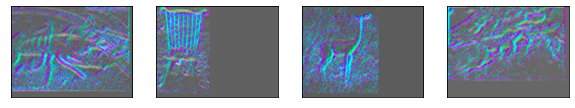

In [59]:
show_image_row([representation_vizualization2.cpu()])

In [31]:
np.shape(representation_vizualization)

torch.Size([3, 184, 970])

In [78]:
import torch
import torch.nn.functional as F

src = torch.arange(25, dtype=torch.float).reshape(1, 1, 5, 5).requires_grad_()  # 1 x 1 x 5 x 5 with 0 ... 25
indices = torch.tensor([[-1, -1], [0, 0]], dtype=torch.float).reshape(1, 1, -1, 2)  # 1 x 1 x 2 x 2
output = F.grid_sample(src, indices)
print(output)  # tensor([[[[  0.,  12.]]]])

tensor([[[[ 0., 12.]]]], grad_fn=<GridSampler2DBackward>)


In [79]:
src

tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]], requires_grad=True)

In [80]:
indices

tensor([[[[-1., -1.],
          [ 0.,  0.]]]])

In [81]:
output

tensor([[[[ 0., 12.]]]], grad_fn=<GridSampler2DBackward>)